In [26]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import LSTM,Dense,Input

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='CksY-92OBcPex5E-MwaGfkfoTkQW6wen5HVtZ1LXGMOK',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'crudeoilpriceprediction-donotdelete-pr-vtg7hvlasgnhuz'
object_key = 'Crude Oil Prices Daily.xlsx'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']

data = pd.read_excel(body.read())

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
metadata_1 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-5d623ebb-fdda-4e0c-baa0-104a5991e97f',
    'IBM_API_KEY_ID': 'CksY-92OBcPex5E-MwaGfkfoTkQW6wen5HVtZ1LXGMOK',
    'ENDPOINT': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'crudeoilpriceprediction-donotdelete-pr-vtg7hvlasgnhuz',
    'FILE': 'Crude Oil Prices Daily.xlsx'
}

In [2]:
data.head()

,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [3]:
data.dropna(axis=0, inplace = True)
data.isnull().sum()

Date             0
Closing Value    0
dtype: int64

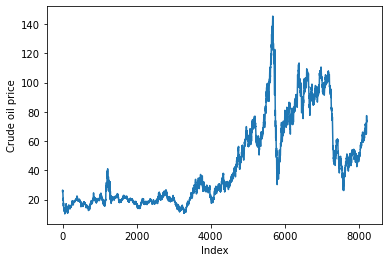

In [4]:
plt.plot(data.index,data['Closing Value']) #univariate analysis
plt.xlabel('Index')
plt.ylabel('Crude oil price')
plt.show()

In [6]:
train_set = data.iloc[:,1:2].values # choosing only required columns
train_set

array([[25.56],
       [26.  ],
       [26.53],
       ...,
       [73.05],
       [73.78],
       [73.93]])

In [11]:
data.shape

(8216, 2)

In [10]:
batch_size = 64
epochs = 120
timesteps = 30
length = len(data)
print (length)

#test set will be 20% of entire data set  
length = length - int(length *0.20)
print (length)

8216
6573


In [13]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length = length - int(length *test_percent)
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
    return (max(train_length_values))

In [15]:
length = get_train_length(data, batch_size, 0.20)
print (length)

6528
6528


In [16]:
#Adding timesteps * 2
upper_train = length + timesteps*2
data_train = data[0:upper_train]
training_set = data_train.iloc[:,1:2].values
training_set.shape

(6588, 1)

In [17]:
scale = MinMaxScaler(feature_range = (0, 1)) #scaling the dataset
training_set_scaled = scale.fit_transform(np.float64(training_set))
training_set_scaled.shape

(6588, 1)

In [21]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print (length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print (len(X_train))
print (len (y_train))
print (np.array(X_train).shape)
print (np.array(y_train).shape)

6558
6528
6528
(6528, 30)
(6528, 30)


In [22]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print (X_train.shape)
print (y_train.shape)

(6528, 30, 1)
(6528, 30, 1)


# Model Creation


In [27]:
inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(64, 30, 1)]             0         
                                                                 
 lstm_2 (LSTM)               (64, 30, 10)              480       
                                                                 
 lstm_3 (LSTM)               (64, 30, 10)              840       
                                                                 
 dense_1 (Dense)             (64, 30, 1)               11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [28]:
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 0
102/102 [==============================] - 4s 17ms/step - loss: 0.0390
Epoch: 1
102/102 [==============================] - 2s 17ms/step - loss: 0.0529
Epoch: 2
102/102 [==============================] - 3s 31ms/step - loss: 0.0430
Epoch: 3
102/102 [==============================] - 2s 17ms/step - loss: 0.0376
Epoch: 4
102/102 [==============================] - 1s 14ms/step - loss: 0.0340
Epoch: 5
102/102 [==============================] - 2s 17ms/step - loss: 0.0331
Epoch: 6
102/102 [==============================] - 2s 20ms/step - loss: 0.0324
Epoch: 7
102/102 [==============================] - 2s 17ms/step - loss: 0.0318
Epoch: 8
102/102 [==============================] - 2s 18ms/step - loss: 0.0313
Epoch: 9
102/102 [==============================] - 2s 23ms/step - loss: 0.0309
Epoch: 10
102/102 [==============================] - 2s 22ms/step - loss: 0.0306
Epoch: 11
102/102 [==============================] - 2s 19ms/step - loss: 0.0303
Epoch: 12
102/102 [===================

102/102 [==============================] - 2s 21ms/step - loss: 0.0272
Epoch: 102
102/102 [==============================] - 2s 21ms/step - loss: 0.0279
Epoch: 103
102/102 [==============================] - 2s 20ms/step - loss: 0.0289
Epoch: 104
102/102 [==============================] - 2s 22ms/step - loss: 0.0284
Epoch: 105
102/102 [==============================] - 3s 29ms/step - loss: 0.0279
Epoch: 106
102/102 [==============================] - 2s 22ms/step - loss: 0.0276
Epoch: 107
102/102 [==============================] - 3s 26ms/step - loss: 0.0275
Epoch: 108
102/102 [==============================] - 2s 20ms/step - loss: 0.0274
Epoch: 109
102/102 [==============================] - 2s 17ms/step - loss: 0.0274
Epoch: 110
102/102 [==============================] - 2s 16ms/step - loss: 0.0274
Epoch: 111
102/102 [==============================] - 1s 13ms/step - loss: 0.0273
Epoch: 112
102/102 [==============================] - 2s 17ms/step - loss: 0.0272
Epoch: 113
102/102 [=======

# Model test 

In [29]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print (x)
    return (max(test_length_values))

In [30]:
test_length = get_test_length(data, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print (testset_length)

8060
8124
8124
1536


In [32]:
# construct test set

#subsetting
df_data_1_test = data[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = scale.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [35]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print (predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print (predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = scale.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print (y_test.shape)

(1536, 30, 1)
(1536, 30)
(1506, 1)


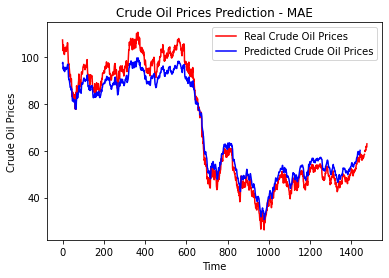

In [36]:
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [51]:
print(np.any(np.isnan(test_set)))
print(np.any(np.isnan(y_test)))

True
True


In [60]:
np.nan_to_num(test_set,copy=False)


array([[100.39],
       [100.82],
       [101.82],
       ...,
       [ 70.7 ],
       [ 70.96],
       [ 71.31]])

In [61]:
np.nan_to_num(y_test,copy=False)

array([[97.45027161],
       [97.74362183],
       [96.85579681],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [62]:
print(np.any(np.isnan(test_set)))
print(np.any(np.isnan(y_test)))

False
False


In [63]:
from sklearn.metrics import mean_absolute_error
mae = float(mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(mae)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

5.508182944217671
9.915449330124693


In [64]:
regressor_mae.save("Crude_oil_LSTM_prediction.h5")

In [65]:
# compress the file
!tar -zcvf crudeoil_prediction_model.tgz Crude_oil_LSTM_prediction.h5

Crude_oil_LSTM_prediction.h5


# IBM deployment

In [66]:
pip install ibm_watson_machine_learning

Note: you may need to restart the kernel to use updated packages.


In [67]:
from ibm_watson_machine_learning import APIClient

In [71]:
wmi_credentials={
    "url":"https://us-south.ml.cloud.ibm.com",
    "apikey":"9RsKJwBgAvBgaBdJb5NY4pFp2hP-z_rV3jEVTEkRNdmm"
}

In [72]:
client = APIClient(wmi_credentials)

In [74]:
client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ----------------  ------------------------
ID                                    NAME              CREATED
90c5aed6-96c9-4761-b1d2-eab8fbdd04db  crude oil price   2022-11-10T05:21:13.209Z
eb3cc34c-e09d-4643-b089-c777baff0506  flowers_identify  2022-10-25T11:51:00.457Z
------------------------------------  ----------------  ------------------------


In [75]:
space_id="90c5aed6-96c9-4761-b1d2-eab8fbdd04db"

In [76]:
client.set.default_space(space_id)

'SUCCESS'

In [77]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
runtime-22.1-py3.9             12b83a1

In [78]:
software_space_uid=client.software_specifications.get_id_by_name("tensorflow_rt22.1-py3.9")

In [80]:
software_space_uid

'acd9c798-6974-5d2f-a657-ce06e986df4d'

In [83]:
model_details=client.repository.store_model(model='crudeoil_prediction_model.tgz',meta_props={
    client.repository.ModelMetaNames.NAME:"LSTM Model",
    client.repository.ModelMetaNames.TYPE:"tensorflow_2.7",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid
})